# Obtaining the Data

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"noobie1999","key":"14463ecf429669d48f4782325aefcfe2"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [00:52<00:00, 123MB/s]
100% 5.20G/5.20G [00:52<00:00, 106MB/s]


In [0]:
from zipfile import ZipFile
file_name = "skin-cancer-mnist-ham10000.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


# Data Preprocessing

In [0]:
import cv2
import matplotlib.pyplot as plt
import sys
import pandas as pd
import os
import glob
import numpy as np
import random

In [0]:
DATADIR = "/content/"

all_image_path = glob.glob(os.path.join(DATADIR, '*', '*.jpg'))
image_path_dict = {os.path.splitext(os.path.basename(x))[0]:x for x in all_image_path}

In [0]:
liesons = ['akiec','bcc','bkl','nv','df','mel','vasc']

def create_softmax(x):
    a = [0,0,0,0,0,0,0]
    a[liesons.index(x)] = 1
    return a


In [0]:
df = pd.read_csv("HAM10000_metadata.csv")
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [0]:
df['image_path'] = df['image_id'].map(image_path_dict.get)

In [0]:
#get image parameters

IMAGE_SIZE = (100,100)
print(IMAGE_SIZE)

(100, 100)


#Image Preprocessing

In [0]:
def noisy(noise_typ,image):
  
  if noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noise = np.random.poisson(image).astype(float)
      noisy = image + noise
      return noisy

  elif noise_typ == "gauss":
      row,col= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy

  elif noise_typ == "s&p":
      prob = 0.05
      output = np.zeros(image.shape,np.uint8)
      thres = 1 - prob 
      for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
      return output


In [0]:
noise_type = ["gauss", "poisson", "s&p"]

In [0]:
def segmentation(image):
  row, col = image.shape
  image_r = image.reshape(row*col)
  image_mean = image_r.mean()
  for i in range(image_r.shape[0]):
    if(image_r[i]>image_mean):
      image_r[i] = 255
  image_segmented = image_r.reshape(row, col)
  return image_segmented

In [0]:
def create_dataset():
  
  dataset = []
  
  for index in df.index:
    image = cv2.resize(cv2.imread(df.image_path[index], cv2.IMREAD_GRAYSCALE), IMAGE_SIZE)
    noisy_image = noisy(random.choice(noise_type), image)
    restored_image = cv2.medianBlur(np.float32(noisy_image), 5)
    cv2.imwrite("restoredimage.jpg", restored_image)
    restored_image = cv2.imread("restoredimage.jpg", cv2.IMREAD_GRAYSCALE)
    enhanced_image = cv2.equalizeHist(restored_image)
    cv2.imwrite("equalizedimage.jpg", enhanced_image)
    equalized_image = cv2.imread("equalizedimage.jpg", cv2.IMREAD_GRAYSCALE)
    segmented_image = segmentation(equalized_image)
    cv2.imwrite("segmentedimage.jpg", segmented_image)
    image = cv2.imread("segmentedimage.jpg", cv2.IMREAD_GRAYSCALE)
    label = liesons.index(df.dx[index])
    dataset.append([image, label])
  
  
  return dataset

In [0]:
image_dataset = create_dataset()

random.shuffle(image_dataset)

In [0]:
def create_sample_dataset(x):
  X = []
  y = []
  
  for features, label in x:
    X.append(features)
    y.append(label)
  
  X = np.array(X).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
  y = np.array(y)
  
  return X,y

In [0]:
X, y = create_sample_dataset(image_dataset)



```
# This is formatted as code
```

# Convolutional Neural Network

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
X = X/255.0

print(X.shape)
print(y.shape)

(10015, 100, 100, 1)
(10015,)


In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3,3), input_shape=X.shape[1:], kernel_initializer='glorot_normal'))
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64, (3,3), kernel_initializer="glorot_normal"))
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(128, (3,3), kernel_initializer="glorot_normal"))
cnn_model.add(Activation("relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


cnn_model.add(Flatten())
cnn_model.add(Dense(128, kernel_initializer="glorot_normal", bias_initializer="glorot_normal"))


cnn_model.add(Dense(7))
cnn_model.add(Activation("softmax"))

cnn_model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy',recall_m, precision_m,f1_m])


cnn_history = cnn_model.fit(X, y, batch_size=128, epochs=5 ,validation_split=0.05)

Train on 9514 samples, validate on 501 samples
Epoch 1/5
9514/9514 [==============================] - 2s 231us/sample - loss: 1.1355 - acc: 0.6630 - recall_m: 1.3709 - precision_m: 158266656.0000 - f1_m: 1.5917 - val_loss: 1.0235 - val_acc: 0.6727 - val_recall_m: 1.2551 - val_precision_m: 1.4568 - val_f1_m: 1.3483
Epoch 2/5
9514/9514 [==============================] - 2s 193us/sample - loss: 0.9984 - acc: 0.6778 - recall_m: 1.3773 - precision_m: 1.7685 - f1_m: 1.5445 - val_loss: 0.9649 - val_acc: 0.6727 - val_recall_m: 1.4220 - val_precision_m: 1.7882 - val_f1_m: 1.5841
Epoch 3/5
9514/9514 [==============================] - 2s 192us/sample - loss: 0.9484 - acc: 0.6847 - recall_m: 1.3916 - precision_m: 1.7865 - f1_m: 1.5618 - val_loss: 0.9537 - val_acc: 0.6806 - val_recall_m: 1.3097 - val_precision_m: 1.5798 - val_f1_m: 1.4318
Epoch 4/5
9514/9514 [==============================] - 2s 192us/sample - loss: 0.9065 - acc: 0.6959 - recall_m: 1.3951 - precision_m: 1.7602 - f1_m: 1.5538 - val_

#Performance Analysis

## 1. Accuracy

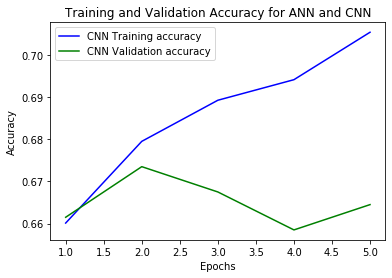

In [0]:
cnn_acc = cnn_history.history["acc"]
cnn_val_acc = cnn_history.history["val_acc"]

epochs = range(1, len(cnn_acc)+1, 1)

plt.plot(epochs, cnn_acc, 'b', label="CNN Training accuracy")
plt.plot(epochs, cnn_val_acc, 'g', label="CNN Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy for ANN and CNN")
plt.legend()
plt.show()

## 2. Loss

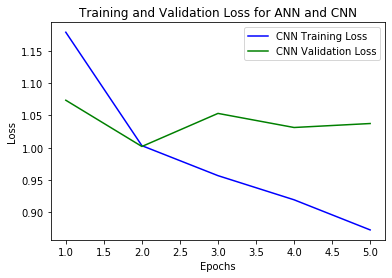

In [0]:
cnn_loss = cnn_history.history["loss"]
cnn_val_loss = cnn_history.history["val_loss"]

epochs = range(1, len(cnn_loss)+1,1)

plt.plot(epochs, cnn_loss,'b', label="CNN Training Loss")
plt.plot(epochs, cnn_val_loss, 'g', label="CNN Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for ANN and CNN")
plt.legend()
plt.show()

## 3. Recall

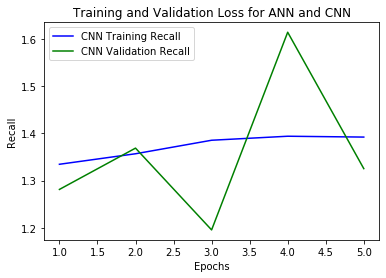

In [0]:
cnn_recall = cnn_history.history["recall_m"]
cnn_val_recall = cnn_history.history['val_recall_m']

epochs = range(1, len(cnn_recall)+1, 1)

plt.plot(epochs, cnn_recall,'b', label="CNN Training Recall")
plt.plot(epochs, cnn_val_recall, 'g', label="CNN Validation Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Training and Validation Loss for ANN and CNN")
plt.legend()
plt.show()

## 4. Precision

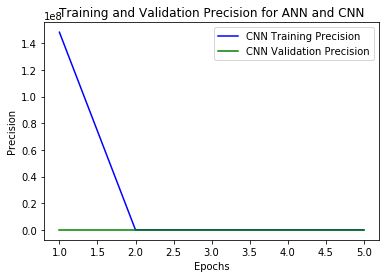

In [0]:
cnn_precision = cnn_history.history["precision_m"]
cnn_val_precision = cnn_history.history["val_precision_m"]

epochs = range(1, len(cnn_precision)+1, 1)

plt.plot(epochs, cnn_precision,'b', label="CNN Training Precision")
plt.plot(epochs, cnn_val_precision, 'g', label="CNN Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision for ANN and CNN")
plt.legend()
plt.show()

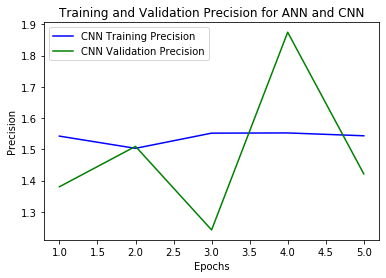

In [0]:
cnn_f1 = cnn_history.history["f1_m"]
cnn_val_f1 = cnn_history.history["val_f1_m"]

epochs = range(1, len(cnn_precision)+1, 1)

plt.plot(epochs, cnn_precision,'b', label="CNN Training Precision")
plt.plot(epochs, cnn_val_precision, 'g', label="CNN Validation Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Training and Validation Precision for ANN and CNN")
plt.legend()
plt.show()

In [0]:
print(X.shape)

(10015, 100, 100, 1)


In [0]:
X = X.reshape(-1, 10000)

In [0]:
X.shape

(10015, 10000)